# Coursera Applied Machine Learning Final Assignment
## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/datasets/building-permits?geometry=-83.753%2C42.265%2C-82.446%2C42.442)
* [Trades Permits](https://data.detroitmi.gov/datasets/trades-permits?geometry=-83.753%2C42.265%2C-82.446%2C42.443)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/datasets/improve-detroit-issues?geometry=-87.344%2C41.829%2C-82.117%2C42.541)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/datasets/dpd-citizen-complaints)
* [Parcel Map](https://cityofdetroit.github.io/parcel-viewer/)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

# INTRODUCTION

In this project, we will create a predictive model to see whether blight violators in Detroit will comply and pay the fine or not.<br>
In the training data, if the ticket was paid early, on time, or within one month of the hearing data the violators will be marked as **True** (1), if the ticket was paid after the hearing date or not at all the violators will be marked as **False** (0).
<br><br>
Several model/classifier and feature engineering will be performed in this project to be compared. The model that will be used are:
1. Gradient Boosted Tree
2. Random Forest
3. SVC
4. Naive Bayes Classifier

Several metrices will also be used as the model assessment, however, the Area Under the ROC Curve (AUC) will be our main metric. List of metrices will be used:
1. **Area under the ROC curve (AUC)**
2. Confussion Matrix
3. Precision, Recal, F1

Before we start our modelling, first we need to take a quick look at our data

# Data Wrangling

In this stage, we will import the libraries and the dataset, then look at our data by these aspects:
1. Completeness
2. General information & general distribution

And **prepare** it for our modelling purpose.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv', engine = 'python')
test = pd.read_csv('test.csv')
addresses = pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')

In [3]:
# Since there are no compliance data with NaN value in test data, 
# we will only use data which compliance has a value in the training data
train = train[train['compliance'].notna()]

## Completeness
Check for missing value

In [4]:
print(train.info(),'\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 0 to 250293
Data columns (total 34 columns):
ticket_id                     159880 non-null int64
agency_name                   159880 non-null object
inspector_name                159880 non-null object
violator_name                 159854 non-null object
violation_street_number       159880 non-null float64
violation_street_name         159880 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    157322 non-null float64
mailing_address_str_name      159877 non-null object
city                          159880 non-null object
state                         159796 non-null object
zip_code                      159879 non-null object
non_us_str_code               3 non-null object
country                       159880 non-null object
ticket_issued_date            159880 non-null object
hearing_date                  159653 non-null object
violation_code                159880 non-null obj

As seen above, the train data have 2 columns that only have null value (*violation_zip_code* and *grafitti_status*) which in contrast have values in the test data. Unlike *grafitti_status* that may have information behind the null value (we will see this later), zip_code values varies rather widely, so we will drop this columns both in test and train set.

In [5]:
common_drop = ['violation_zip_code']

train.drop(common_drop, axis=1, inplace=True)
test.drop(common_drop, axis=1, inplace=True)

In [6]:
print(addresses.info(), '\n')
print(latlons.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311307 entries, 0 to 311306
Data columns (total 2 columns):
ticket_id    311307 non-null int64
address      311307 non-null object
dtypes: int64(1), object(1)
memory usage: 4.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121769 entries, 0 to 121768
Data columns (total 3 columns):
address    121769 non-null object
lat        121762 non-null float64
lon        121762 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB
None


## General Information and Distribution

In this stage, we will see the general information and distribution of the train and test dataset. We will use this information to understand our data better and to check features that may lead to **leakage**.

In [7]:
print('columns name and its number of unique value')
for j,k in zip([train, test], ['Train','Test']):
    if k == 'Train':
        print("=========TRAIN==========")
    else:
        print("=========TEST===========")
    for i in j.columns:
        print (i,":",j[i].nunique())

columns name and its number of unique value
=========TRAIN==========
ticket_id : 159880
agency_name : 5
inspector_name : 159
violator_name : 84656
violation_street_number : 18096
violation_street_name : 1716
mailing_address_str_number : 14090
mailing_address_str_name : 28440
city : 4093
state : 59
zip_code : 3498
non_us_str_code : 2
country : 5
ticket_issued_date : 68097
hearing_date : 5970
violation_code : 189
violation_description : 207
disposition : 4
fine_amount : 40
admin_fee : 1
state_fee : 1
late_fee : 37
discount_amount : 13
clean_up_cost : 1
judgment_amount : 57
payment_amount : 522
balance_due : 606
payment_date : 2307
payment_status : 3
collection_status : 1
grafitti_status : 0
compliance_detail : 8
compliance : 2
=========TEST===========
ticket_id : 61001
agency_name : 3
inspector_name : 116
violator_name : 38515
violation_street_number : 13999
violation_street_name : 1477
mailing_address_str_number : 9703
mailing_address_str_name : 16851
city : 3266
state : 58
zip_code : 2

### Potential Leakage
As seen above, in the training data, there are several features that may lead to data leakage, namely:
1. payment_amount
2. balance_due
3. payment_date
4. payment_status
5. collection_status
6. compliance_detail

These informations indicate whether or not the violators comply and pay the fine, so we need to separate these features from our train dataset. Also, for now, lets neglect the time features. However, this feature may be used if necessary.

In [8]:
#dropping fields that may lead to data leakage
pot_leak = ['payment_amount','balance_due','payment_date','payment_status','collection_status','compliance_detail']
time = ['ticket_issued_date', 'hearing_date']
#dropping fields that not used in the training
train = train.drop(pot_leak, axis=1)

### Imbalance Dataset

We will check the data distribution, to see whether or not the dataset we have is imbalance. <br>
As shown below, the ratio of True and False compliance is way off, meaning the data is imbalanced. This imply that accuracy won't be a good metric to assess our model.

In [9]:
# print(train['compliance'].unique())
print("Number of data with TRUE compliance value in train dataset:",len(train[train['compliance']==1]))
print("Number of data with FALSE compliance value in train dataset:",len(train[train['compliance']==0]))
print("TRUE to FALSE compliance status ratio: {:.3f}".format(len(train[train['compliance']==1])/len(train[train['compliance']==0])))

Number of data with TRUE compliance value in train dataset: 11597
Number of data with FALSE compliance value in train dataset: 148283
TRUE to FALSE compliance status ratio: 0.078


## Data Preparation for Modelling purpose, Categorization

For our modelling purpose, we will change the data type into categories

In [10]:
# concatenating both dataframes for categorization
df = pd.concat([train, test], sort = False).set_index('ticket_id')
len(train), len(test), len(train)+len(test), len(df)

(159880, 61001, 220881, 220881)

In [11]:
cat_features = ['agency_name', 'inspector_name', 'violator_name', 'violation_street_name','mailing_address_str_name',
               'city','state','non_us_str_code','country','violation_code','violation_description','disposition',
               'grafitti_status', 'zip_code']
for col in cat_features:
    df[col] = df[col].astype('category') 
df[cat_features] = df[cat_features].apply(lambda x: x.cat.codes)

In [13]:
# Splitting the dataframes back to test and train
train = df.iloc[0:len(train),:]
test = df.iloc[len(train):,:]
test = test.drop('compliance', axis = 1)
len(test)

61001

# Modelling Comparison

## Using only 'money' fields to predict compliance

We will see how predictive the 'money' fields in this case. We will use different classifier to check its consistency.

In [14]:
from sklearn.model_selection import train_test_split

# these are the classifiers that will be used
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# these are the metrices will be used
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.options.display.max_columns = None

Separate the 'money' fields to make it as our feature for the model. Make the train and validation set from the **train** data

In [15]:
# prepare the money train and validation dataset from the the money columns

money = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost']
money_Xtrain = train[money]
# money_Xtrain.head()

# prepare the target

money_ytrain = train['compliance']
# len(money_Xtrain), len(money_ytrain)

X_train, X_test, y_train, y_test = train_test_split(money_Xtrain, money_ytrain, random_state=0)

In [16]:
# prepare the money test dataset, in this case, since test data set doesn't provide the target,
# this is better called as prediction dataset

money_Xtest = test[money]
# money_Xtest.head()

### Apply different Models as Classifiers
We will use the default settings of each classifiers and then check its performance with some metrics

In [17]:
# GRADIENT BOOSTED TREE
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [26]:
# RANDOM FOREST
rf = RandomForestClassifier(random_state=0, n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
# NAIVE BAYES
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [53]:
# SVC
svc = SVC(random_state=0, gamma = 'auto', probability = True)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

### Model assesment

In [54]:
confusion_gbc = confusion_matrix(y_test, gbc.predict(X_test))
confusion_rf = confusion_matrix(y_test, rf.predict(X_test))
confusion_gnb = confusion_matrix(y_test, gnb.predict(X_test))
confusion_svc = confusion_matrix(y_test, svc.predict(X_test))
print("GBC Confusion matrix:\n{}\n".format(confusion_gbc))
print("RF Confusion matrix:\n{}\n".format(confusion_rf))
print("GNB Confusion matrix:\n{}\n".format(confusion_gnb))
print("GNB Confusion matrix:\n{}".format(confusion_svc))

GBC Confusion matrix:
[[37063    15]
 [ 2599   293]]

RF Confusion matrix:
[[37063    15]
 [ 2599   293]]

GNB Confusion matrix:
[[37063    15]
 [ 2633   259]]

GNB Confusion matrix:
[[37063    15]
 [ 2600   292]]


In [55]:
print('GBC classification report\n',classification_report(y_test, gbc.predict(X_test)))
print('RF classification report\n',classification_report(y_test, rf.predict(X_test)))
print('GNB classification report\n',classification_report(y_test, gnb.predict(X_test)))
print('SVC classification report\n',classification_report(y_test, svc.predict(X_test)))

GBC classification report
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     37078
         1.0       0.95      0.10      0.18      2892

    accuracy                           0.93     39970
   macro avg       0.94      0.55      0.57     39970
weighted avg       0.94      0.93      0.91     39970

RF classification report
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     37078
         1.0       0.95      0.10      0.18      2892

    accuracy                           0.93     39970
   macro avg       0.94      0.55      0.57     39970
weighted avg       0.94      0.93      0.91     39970

GNB classification report
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     37078
         1.0       0.95      0.09      0.16      2892

    accuracy                           0.93     39970
   macro avg       0.94      0.54      0.56     

In [56]:
# ROC parameters for Gradient Boosted Tree
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, gbc.predict_proba(X_test)[:, 1])
roc_auc_grd_gbc = auc(fpr_gbc, tpr_gbc)

# ROC parameters for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_grd_rf = auc(fpr_rf, tpr_rf)

# ROC parameters for Naive Bayes
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, gnb.predict_proba(X_test)[:, 1])
roc_auc_grd_gnb = auc(fpr_gnb, tpr_gnb)

# ROC parameters for SVC
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc.predict_proba(X_test)[:, 1])
roc_auc_grd_svc = auc(fpr_svc, tpr_svc)

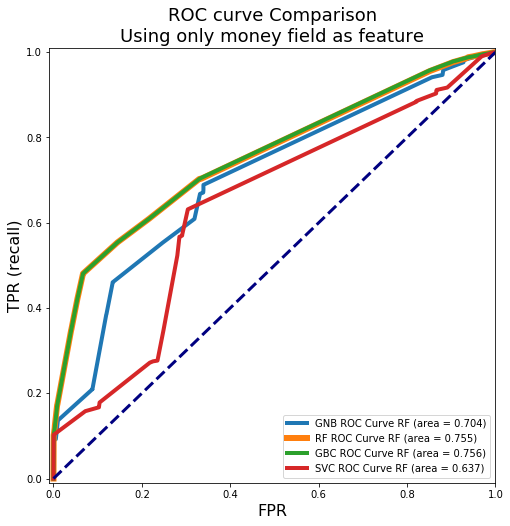

In [68]:
fig, ax = plt.subplots(figsize = (8,8))

plt.plot(fpr_gnb, tpr_gnb, label="GNB ROC Curve RF (area = {:0.3f})".format(roc_auc_grd_gnb), lw = 4)
plt.plot(fpr_rf, tpr_rf, label="RF ROC Curve RF (area = {:0.3f})".format(roc_auc_grd_rf), lw = 6)
plt.plot(fpr_gbc, tpr_gbc, label="GBC ROC Curve RF (area = {:0.3f})".format(roc_auc_grd_gbc), lw = 4)
plt.plot(fpr_svc, tpr_svc, label="SVC ROC Curve RF (area = {:0.3f})".format(roc_auc_grd_svc), lw = 4)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR (recall)", fontsize=16)
plt.title('ROC curve Comparison\nUsing only money field as feature', fontsize=18)
plt.legend(loc=4)

# Conclusion

Without performing any preprocessing and parameter tuning, we see that from the 'money' fields, **Gradient Boosted Tree Classifier** performs best compared to other classifier (Random Forest, Gaussian Naive Bayes, and SVC). This is based on their ROC score, detailed as follows:

1. GBC : 0.756
2. RF  : 0.755
3. GNB : 0.704
4. SVC : 0.637

GBC performs insignificantly better than RF, this is also consistent to their confussion matrix.<br>
In this type of data, SVC perform the worst also in its runtime length. I also tried to rescale the data for the SVC, but the result is oddly even worse than the default SVC.
<br><br>
For the next part, we will dig more on feature engineering and parameter tuning to improve ROC score of the GBC